In [1]:
import glob 
import os 
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np

import pandas as pd 
from torch.utils.data import Dataset, DataLoader
from torchvision import  utils

from PIL import Image

In [2]:
cwd = os.getcwd()
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")

feature_size=2048
cnn_feature_extractor=torchvision.models.resnet50(pretrained=True) #resnet50 fc is for 1000 calsses
#modules = list(cnn_feature_extractor.children())[:-1] # delete the last fc layer.
#cnn_feature_extractor = nn.Sequential(*modules).to(device)

# set requires_grad to false
for param in cnn_feature_extractor.parameters():
    param.requires_grad = False
print(cnn_feature_extractor)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [43]:
target_domain='sketch' # change here 
domain_name=['sketch','quickdraw','infograph','real']
domain_name.remove(target_domain)

class_name=[file  for file in os.listdir(domain_name[0]) if file[-3:] !='csv' ]

csv_name_train={name: pd.read_csv(cwd+'/'+name+'/'+name+ '_train.csv',index_col=0) for name in domain_name}
csv_name_test={target_domain: pd.read_csv(cwd+'/'+target_domain+'/'+target_domain+ '_test.csv',index_col=0)}




In [46]:
train_cvs=pd.concat(csv_name_train[key] for key in domain_name)



In [49]:
list(train_cvs.index)

['quickdraw/aircraft_carrier/quickdraw_000_000000.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000001.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000002.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000003.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000004.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000005.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000006.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000007.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000008.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000009.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000010.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000011.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000012.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000013.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000014.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000015.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_000016.jpg',
 'quickdraw/aircraft_carrier/quickdraw_000_00001

In [63]:
color_transform=transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])

class finalset(Dataset):
    def __init__(self, train_cvs,train, transform=None):
        """ Intialize the MNIST dataset """
        self.images = None
        self.labels = None
        self.csv=train_cvs
        self.filenames = list(train_cvs.index)
        self.train=train
        self.transform = transform
        self.len = len(self.filenames)                      
    def __getitem__(self, index):

        """ Get a sample from the dataset """
        
        image_fn=self.filenames[index]
        image = Image.open(image_fn)
    
        if image.mode != 'RGB':
            image = np.expand_dims(image, axis=2)
            image=np.concatenate((image,image,image),axis=2)

        if self.transform is not None:
            image = self.transform(image)
        
        if self.train is True:
            label=self.csv.loc[image_fn,'label']
            return image,label,image_fn
        if self.train is False:
            return image, -1, image_fn
    
    def __len__(self):
        return self.len  

train_data  =finalset(train_cvs,train=True,transform=color_transform)
trainloader = DataLoader(train_data, batch_size=64,shuffle=True) 

In [74]:
img_list=[]
for batch_idx, data in enumerate(trainloader):
    if batch_idx >= 20:  # to get only 512 samples
            break
    input1, label1, filenames = data
    input1= input1.cuda()
    img_list.append(input1.view(64,-1))
    
    
    

In [82]:
img_feautures = []
for seq_feature in img_list:
    
    img_feautures.append(seq_feature.cpu().numpy())
    

img_features = np.array(img_feautures)
img_features=np.reshape(img_features,(20*64,-1))

In [86]:
img_features.shape
   

(1280, 150528)

In [89]:
from sklearn.manifold import TSNE
CNN_features_2d = TSNE(n_components=2, perplexity=30).fit_transform(img_features)

TypeError: You must first set_array for mappable

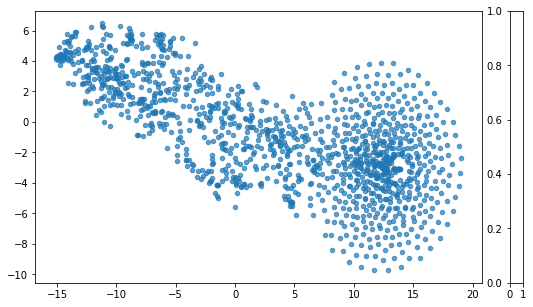

In [92]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
cm = plt.cm.get_cmap("tab20", 11)
plt.figure(figsize=(10,5))
plt.scatter(CNN_features_2d[:,0], CNN_features_2d[:,1],s=20 , c=valid_y,cmap=cm,alpha=0.7)
plt.colorbar(ticks=range(11))
plt.clim(-0.5, 10.5)
plt.savefig("CNN_tsne.png")
plt.show()